In [1]:
import ray

ray.init(ignore_reinit_error=True)

2024-02-14 08:39:40,935	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.11.4
Ray version:,2.8.1


In [2]:
ray.__version__

'2.8.1'

In [3]:
#!pip install ray

#!pip install dm_tree
#!pip install gymnasium
#!pip install pyarrow
#!pip install lz4
#!pip install gymnasium[classic-control] This didn't work so I installed:
#!pip install pygame
#!pip install GPUtil

#!pip install mujoco
#!pip install pybullet
#!brew install swig
#!pip install box2d-py
#!pip install --upgrade "jax[cpu]"

In [4]:
from ray.rllib.algorithms.algorithm import Algorithm
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

In [5]:
from fastcore.xtras import Path
import re

#path to saved results
path=Path('.').resolve()/'saved_agents'/'my_tune_run_1'
# just get the folder directories
fldrs=[p for p in path.ls() if p.is_dir()]

#find value after episode_reward_mean:
pattern = r'"episode_reward_mean":\s*([-+]?\d*\.\d+|\d+)'

best_avg_reward=0; best_fldr=''
for i, fldr in enumerate(fldrs):
    # Ray saves the json files incorrectly and they error out 
    fname=fldr/'result.json'
    if fname.exists():
        with open(fname, 'r') as f:
            dct = f.read()
            f.close()

        mx_rwrd=np.array(re.findall(pattern, dct), dtype=float).max()        
        # save the name of folder with teh highest average reward
        if best_avg_reward< mx_rwrd:
            best_avg_reward= mx_rwrd
            best_fldr=fldr


In [6]:
ckpts=[p.stem for p in best_fldr.ls() if p.is_dir() and str(p).find('checkpoint')!=-1]

In [7]:
algo_path=best_fldr/max(ckpts); 
algo_path.parts[-2:], best_avg_reward

(('PPO_CartPole-v1_03239_00000_0_2023-12-07_11-02-24', 'checkpoint_000000'),
 490.69)

In [8]:
algo = Algorithm.from_checkpoint(algo_path)

2024-02-14 08:39:54,977	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/r

In [9]:
policy = algo.get_policy()

In [10]:
policy.model

PPOTorchRLModule(
  (encoder): TorchActorCriticEncoder(
    (actor_encoder): TorchMLPEncoder(
      (net): TorchMLP(
        (mlp): Sequential(
          (0): Linear(in_features=4, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
        )
      )
    )
    (critic_encoder): TorchMLPEncoder(
      (net): TorchMLP(
        (mlp): Sequential(
          (0): Linear(in_features=4, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
        )
      )
    )
  )
  (pi): TorchMLPHead(
    (net): TorchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
  (vf): TorchMLPHead(
    (net): TorchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)

(RolloutWorker pid=72672) 2024-02-14 08:39:56,714	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(RolloutWorker pid=72672) /Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrap

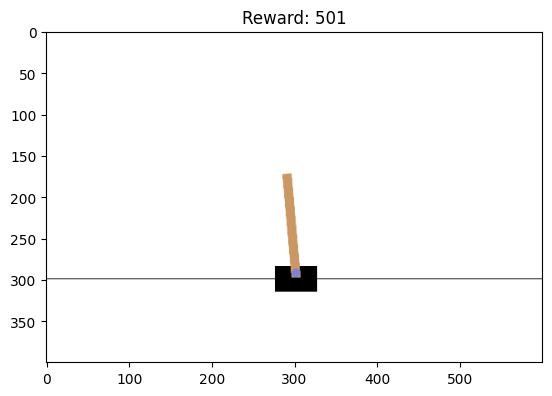

In [16]:
N=50
env_name = "CartPole-v1"

old_gym=False
if gym.__version__=='0.21.0': old_gym=True

    
if old_gym: env = gym.make(env_name)
else: env = gym.make(env_name, render_mode="rgb_array")  

reward_lst=[]
for episode in range(N):
    episode_reward = 0
    
    if old_gym: obs = env.reset()
    else: obs, info = env.reset()

    while True:

        action = algo.compute_single_action(obs)
        
        if old_gym:
            obs, reward, done, info = env.step(action)
        else:
            obs, reward, done, truncated, info = env.step(action)
        
        episode_reward += reward
        if episode == N-1:
            if old_gym==False:
                clear_output(wait=True)
                plt.imshow( env.render())
                plt.title(f'Reward: {int(episode_reward)}')
                plt.show()
            else: env.render()

        if done or episode_reward>500:
            reward_lst.append(episode_reward)
            break


env.close()

In [17]:
pd.Series(reward_lst).describe()

count     50.000000
mean     482.840000
std       64.751128
min      212.000000
25%      501.000000
50%      501.000000
75%      501.000000
max      501.000000
dtype: float64

In [13]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Tuesday December 19, 2023 at 08:32
